QWE is a telecom company suffering from the churning of their members. So far, the churning rate is about 5% and the company is interested in building a model to predict potential churners.

This notebook contains the analysis of data leading to the predictive model. The work consists in data cleaning, deriving new features, exploratory data analysis and hypothesis testing, building of the predictive model and recommendations. The data provided was structured and missing data were previously imputed with 0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chisquare
from random import shuffle

from pprint import pprint
from tabulate import tabulate
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


## functions
def drop_outliers(ps, method=1,center="mean",variable=None):
	"""
	This function removes all outliers. These points are replaced by the mean or median
	method 1: An outlier is defined as a point lying below Q1 - 1.5IQR and above Q3 + 1.5IQR
	Q1: first quartile, Q2: median, Q3: third quartile, IQR: Q3 - Q1.
	method 2: an outlier is any point located 2.5 standard devs, far from the center(mean or median)
	Note: This doesn't work on categorical data
	input: 
		ps (pandas.dataframe or pandas.series): array of numbers to treated
		center (str): default is mean. options: mean, median
	output: pandas.series
	"""
	s = ps.describe().T
	Q1,median,Q3,mean,std = s["25%"],s["50%"],s["75%"],s['mean'], s['std']
	if method == 1:
		IQR = Q3 - Q1
		if IQR == 0:
			print "IQR == 0. ",variable, "needs a closer look"
			return ps
		else:
			ix = ps[(ps < (Q1 - 1.5 * IQR)) | (ps > (Q3 + 1.5 * IQR))].index.tolist()
			return ps
	elif method == 2:
		if center == "mean":
			ix = ps[abs(ps - mean) > 2.5 * std].index.tolist()
			ps.loc[ix] = mean
			return ps
		elif center == "median":
			ix = ps[abs(ps - median) > 2.5 * std].index.tolist()
			ps.loc[ix] = median
			return ps
		else:
			print "unknonw center"
			return ps
	else:
		print "unknonw method"
		return ps
    
def clean_data(data):
    """
    data (pandas.dataframe): raw dataframe to be cleaned
    This method will reformat IDs into integers and will rename original variables
    It will also drop outliers and transform some variables to categorical
    
    inputs:
        data (pandas.dataframe)
    return:
        data (pandas.dataframe)
    """
    # ID to integers
    data['ID'] = range(data.shape[0])

    # rename columns
    data.rename(columns = {'Customer Age (in months)':'Longevity - Months',
        'Churn (1 = Yes, 0 = No)':'Churn',
        'CHI Score Month 0':'Happiness Index - Current Month',
        'CHI Score 0-1':'Happiness Index - Change',
        'Support Cases Month 0':'Support Cases - Current Month',
        'Support Cases 0-1':'Support Cases - Change',
        'SP Month 0':'Support Priority - Current Month',
        'SP 0-1':'Support Priority - Change',
		'Logins 0-1':'Logins - Change',
		'Blog Articles 0-1':'Blogs - Change',
		'Views 0-1':'Views - Change',
		' Days Since Last Login 0-1':'Days Since Last Login - Change'},inplace = True)
    # drop outliers
    centers_dict = {'Support Priority - Change': 'skip', #to be transformed into categorical'Views - Change': 'mean', 
                'Longevity - Months': 'median', 
                'Blogs - Change': 'mean', 
                'Support Cases - Change': 'skip',#to be transformed into categorical. Very unbalanced 
                'Logins - Change': 'mean', 
                'Days Since Last Login - Change': 'mean', 
                'Support Priority - Current Month': 'skip', #to be transformed into categorical
                'Happiness Index - Current Month': 'median', 
                'Happiness Index - Change': 'mean', 
                'Churn': 'skip', #target variable
                'ID': 'skip', #identifier
                'Support Cases - Current Month': 'skip',#to be transformed into categorical. Very unbalanced
                'Views - Change': 'mean'}
    for k,v in centers_dict.iteritems():
        if v != 'skip':
            data[k] = drop_outliers(data[k].copy(), method=2, center=v, variable=k)
            
    # support priority variables to categorical
    data['Support Priority - Change'] = ~(data['Support Priority - Change'] == 0)*1
    data['Support Priority - Current Month'] = ~(data['Support Priority - Current Month'] == 0)*1
    data['Support Cases - Change'] = ~(data['Support Cases - Change'] == 0)*1
    data['Support Cases - Current Month'] = ~(data['Support Cases - Current Month'] == 0)*1

    return data


def standardize(ps,center="mean"):
    """
    This method standardize data to their center and a unity variance
    ps (pandas.series): data to be standardize
    center (str): central point {"mean","median"}
    """
    if center == "mean":
        return (ps - ps.mean()) / ps.std()
    if center == "median":
        return (ps - ps.median()[0]) / ps.std()
    else:
        print "unknown central point"
        return ps

def test_stat(df,ivar,tvar,equal_var=True,ddof=0):
	"""
	This function calculate statistical test to check if means are the same in groups of ivar
	split by tvar
	inputs:
		df (pandas.dataframe): data frame of interest
		ivar (str): indipendent variable
		tvar (str): target variable
	"""
	ivar_uniques = df[ivar].unique().shape[0]
	tvar_uniques = df[tvar].unique().shape[0]
	if tvar_uniques < 2:
		print "Only one sample can be generated"
		return None
	if ivar_uniques <= 10: #This the case of a categorical independant variable. We use chisquare
		ss = pd.crosstab(df[ivar],df[tvar])
		ss = (ss.T/ss.sum(axis=1)).T
		s0,s1 = ss[0].values,ss[1].values

		return chisquare(s1,s0,ddof=ddof)

	if ivar_uniques >10: #Consider using ttest
		s0 = df[ivar][df[tvar] == 0]
		s1 = df[ivar][df[tvar] == 1]
		return ttest_ind(s1,s0,equal_var=equal_var)
def engineer_features(df):
    """
    this function engineer new features for the input dataset
    """
    
    #Since happiness is something that is gained progressively with a customer age and satisfaction, 
    #it is wise to have thise metric. We derive it as the ratio of Happiness Index - Current Month to Longevity.
    df['Happiness Index - Monthly'] = df['Happiness Index - Current Month'] / df['Longevity - Months']
    df['Happiness Index - Monthly'].fillna(df['Happiness Index - Monthly'].mean(),inplace=True)
    
    #Since the barplot of churners showed peaks at longevity 6,12,18 and 24, let's create new features
    for n in [6,12,18,24]:
        df['Longevity - Modulo '+str(n)] = df['Longevity - Months'].mod(n)
        
    df['Logins - Change'] = standardize(df['Logins - Change'].copy())
    df['Blogs - Change'] = standardize(df['Blogs - Change'].copy())
    df['Views - Change'] = standardize(df['Views - Change'].copy())
    df['Customer Activity - Change'] = df[['Logins - Change','Blogs - Change','Views - Change']].mean(axis=1)
    
    return df
def biplot(score,coeff,pcax,pcay,labels=None,nm=None):
    """
    This function generate a scatter plot to visualize important features resulting from a principle component analysis
    Given dataset X, the principle components analysis generates loadings (coefficients) L and scores (new features
    in the new basis) C such that X = L*C
    inputs:
        score (matrix): components in the new basis (C)
        coeff (matrix): also called loadings (L)
        pcax (int): one of the principle components to plot
        pcay (int): another principle to plot
    """
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    if nm == None:
        nm = n
    #construct scales to constrain data between -1 and 1
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    
    #scatter data points in the new basis span by pca1 and pca2
    plt.scatter(xs*scalex,ys*scaley, marker='.',edgecolor='none')
    vectors = []
    
    #overlay transforms of original features in the new basis
    for i in range(n):
        #calculate length of vectors in new basis
        vectors.append((labels[i],np.sqrt(coeff[i,pca1]**2 + coeff[i,pca2]**2)))
        #plot arrow vectors
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='g',alpha=0.5) 
        #add labels
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='k', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    plt.show()
    #print "Feature import (PCA)"
    #print "--------------------"
    vectors = sorted(vectors,key=lambda x:x[1],reverse=False)
    
    plt.barh(range(len(vectors)),map(lambda x:x[1],vectors),edgecolor='none')
    plt.yticks(np.arange(len(vectors))+0.4,map(lambda x:x[0],vectors))
    plt.xlabel('Feature importance')
    plt.grid()
    plt.show()
    #pprint(vectors)
    return vectors

def modelfit(alg, xtr, ytr, performCV=True, printFeatureImportance=True, cv_folds=5,title=None):
    """
    This function perform cross validation (CV) of a model over a training dataset.
    It will print results of the cross validation: mean score, standard deviation, min and max score.
    inputs:
        alg: sklearn algorithm to be trained and validated
        xtr: training dataset
        ytr: target classes for the training dataset
        performCV (bool): performs the CV is true
        printFeatureImportance (bool): print the importance of features. It only works for selectedalogorithms.
        cv_folds (int): subset fold of cross validation
        title (str): title to label generated results
    return (dict): dictionary of the trained and validated model and validation score
    """
    print title
    print "-------------------------------"
    #Fit the algorithm on the data
    alg.fit(xtr, ytr)
    #Predict training set:
    dtrain_predictions = alg.predict(xtr)
    dtrain_predprob = alg.predict_proba(xtr)[:,1]
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, xtr, ytr, cv=cv_folds, scoring='roc_auc')

	#Print model report:
	#print "\nModel Report"
	print "Accuracy: %.4g" % accuracy_score(ytr.values, dtrain_predictions)
	print "AUC Score (Train): %f" % roc_auc_score(ytr, dtrain_predprob)
	
	if performCV:
		print "CV Score: Mean = %.4g | Std = %.4g | Min = %.4g | Max = %.4g" % \
		(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
		
	#Print Feature Importance:
	if printFeatureImportance:
		feat_imp = pd.Series(alg.feature_importances_, xtr.columns.tolist()).sort_values(ascending=False)
		feat_imp.plot(kind='bar', title='Feature Importances')
		plt.ylabel('Feature Importance Score')
		plt.show()
	return {'model':alg,'cv_score':cv_score}

def get_labels(labels_name):
    """
    this returns all labels used in analysis and predictions
    """
    labels = {
        "labels_num":['Blogs - Change', 'Customer Activity - Change', 'Days Since Last Login - Change', 
                      'Happiness Index - Change', 'Happiness Index - Current Month', 'Happiness Index - Monthly', 
                      'Logins - Change', 'Longevity - Modulo 12', 'Longevity - Modulo 18', 'Longevity - Modulo 24', 
                      'Longevity - Months', 'Views - Change'],
        "labels_cat":['Longevity - Modulo 6', 'Support Cases - Change', 'Support Cases - Current Month', 'Support Priority - Change',
                      'Support Priority - Current Month'],
        "target":"Churn",
        "labels_pca":['Happiness Index - Monthly', 'Longevity - Modulo 12', 'Happiness Index - Change', 
                      'Blogs - Change', 'Happiness Index - Current Month', 'Longevity - Modulo 24', 
                      'Customer Activity - Change', 'Logins - Change', 'Longevity - Modulo 18', 
                      'Days Since Last Login - Change']
    }
    return labels[labels_name]
## ========================= stratification sampling class ====================== ##   
class StratSampler():
	def __init__(self,pos,neg,posRate):
		"""
		This is a class for stratification sampling
		inputs:
			pos (list of int): list of indices of positive cases in the dataset
			neg (list of int): list of indices of negative cases in the dataset
			posRate (int): new sought positive rate. Note: posRate > initial rate
		outputs:
			sampledIds (list of int): ordered list of sampled indices
		"""
		self.pos = pos
		self.neg = neg
		self.posRate = posRate

		nchurners=len(self.pos)
		ncustomers = nchurners+len(self.neg)
		ncneeded = (100/self.posRate - 1)*nchurners
		self.ntotal = ncneeded+nchurners
		print "total number of customers:", ncustomers
		print "number of actual churners:", nchurners
		print "total number of non-churners needed to obtain {0}% of churners: {1}".format(self.posRate,ncneeded)
		print "the new sample will be made of {0}. That is {1}% of initial dataset".format(self.ntotal,100*self.ntotal/ncustomers)
		for i in range(100): #randomly reshafle the list of indices
			shuffle(self.pos)
			shuffle(self.neg)
		
		self.posId = self.pos_gen()
		self.negId = self.neg_gen()
		self.sampledIds = self.get_sampled_ids()
	def pos_gen(self): #create a chain (generator) object for positive indices
		for i in self.pos:
			yield i
	def neg_gen(self): #create a chain (generator) object for positive indices
		for i in self.neg:
			yield i
	
	def get_sampled_ids(self):
		"""
		start a loop from 0 to total size of the new sample
		"""
		seed = 123
		#initiate two lists, to save randomly picked positive and negative cases respectively
		positiveIds = []
		negativeIds = []
		i = 0
		print "==> resampling ...  ",
		while len(positiveIds)+len(negativeIds)<self.ntotal:
			# start a loop from 0 to total size of the new sampe
			# if it catches a number divisable by the sought ratio, update the list of positive cases ids
			# otherwise keep update the list of negative cases ids
			try:
				if i%int(100 / self.posRate) == 0: 
					positiveIds.append(self.posId.next())
				else:
					negativeIds.append(self.negId.next())
			except:
				print "Enter posRate higher than the initial rate"
				break
			i+=1
		print "Done sampling"
		print "positive:", len(positiveIds)
		print "negative:", len(negativeIds)
		print "final size:", len(positiveIds)+len(negativeIds)
		#return sorted list of the two list of ids combined
		return sorted(positiveIds+negativeIds)

# Load and clean data

In this section, we load the data. Next, we validate the dataset looking for missing values, invalid data types, ...

In [4]:
data = pd.read_csv('../QWE_INC/QWE Churn Data.csv')
backup = data.copy()

data = clean_data(data)
data.to_csv('QWE_Data.csv',index=False)
data = pd.read_csv('QWE_Data.csv')
print data.info()
#data.to_csv('tmp.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6347 entries, 0 to 6346
Data columns (total 13 columns):
ID                                  6347 non-null int64
Longevity - Months                  6347 non-null float64
Churn                               6347 non-null int64
Happiness Index - Current Month     6347 non-null float64
Happiness Index - Change            6347 non-null float64
Support Cases - Current Month       6347 non-null int64
Support Cases - Change              6347 non-null int64
Support Priority - Current Month    6347 non-null int64
Support Priority - Change           6347 non-null int64
Logins - Change                     6347 non-null float64
Blogs - Change                      6347 non-null float64
Views - Change                      6347 non-null float64
Days Since Last Login - Change      6347 non-null float64
dtypes: float64(7), int64(6)
memory usage: 644.7 KB
None


**Remove outliers**

I consider an outlier to be any point located at 2.5 standard deviation far from the center of data points. The center will be the mean if the distribution of the data is symmetric and the median otherwise.

**Convert some numeric data to categorical data**
Let's now convert support priority variables that we didn't clean off outliers into categorical. The initial visualization showed that about 90% of the data is zero. I opt to generate two categories 0 (zero support priority) and 1 (otherwise)


# Engineering new features

**New feature -> Happiness Index - Monthly** 

Since happiness is something that is gained progressively with a customer age and satisfaction, it is wise to have thise metric. We derive it as the ratio of Happiness Index - Current Month to Longevity.

**New features -> Longevity modulos **

The barplot of churners shows peaks at longevity 6,12,18 and 24
<img src='data/longevity_churners.png'>

Therefore, we alse create new features as longevity modulo 6, 12, 18 and 24

**New feature -> Customer Activity** 

The activity of customers is expressed with any of number of logins, number of blogs read or number of page views. Assuming that these 3 variables contribute equally to the activity of a customer, we can standardize and combine them into one variable that we call "Customer Activity


In [6]:
data = engineer_features(data)

# Stratified Sampling

Before we move on with further analysis, let's split training and validation datasets. We shall also see that there is only 5% of positive churners. This is a case of unbalanced dataset. Therefore, we will use a stratified sampling to boost the positive rate to 20%

In [7]:
labels = ['ID','Blogs - Change', 'Customer Activity - Change', 'Days Since Last Login - Change', 
          'Happiness Index - Change', 'Happiness Index - Current Month', 'Happiness Index - Monthly', 
          'Logins - Change', 'Longevity - Modulo 12', 'Longevity - Modulo 18', 'Longevity - Modulo 24', 
          'Longevity - Modulo 6', 'Longevity - Months', 'Support Cases - Change', 'Support Cases - Current Month', 
          'Support Priority - Change', 'Support Priority - Current Month', 'Views - Change']
labels_num = sorted(['Longevity - Modulo 12', 'Longevity - Months', 'Blogs - Change', 'Days Since Last Login - Change', 
              'Longevity - Modulo 18', 'Logins - Change', 'Longevity - Modulo 24', 
              'Happiness Index - Monthly', 'Happiness Index - Current Month', 'Views - Change', 
              'Customer Activity - Change', 'Happiness Index - Change'])
labels_cat = sorted(['Support Priority - Change', 'Support Priority - Current Month', 
              'Support Cases - Change', 'Support Cases - Current Month',
              'Longevity - Modulo 6'])
labels1 = labels[1:]
target = 'Churn'

In [8]:
from sklearn.model_selection import train_test_split
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

print _Ytrain.value_counts(normalize=True).round(2)

0    0.95
1    0.05
Name: Churn, dtype: float64


In [9]:
positive_ids = _Xtrain[_Ytrain == 1]['ID'].tolist()
negative_ids = _Xtrain[_Ytrain == 0]['ID'].tolist()
sampler = StratSampler(pos=positive_ids, neg=negative_ids, posRate=20)

sample = _Xtrain.loc[sampler.sampledIds]
sample[target] = _Ytrain.loc[sampler.sampledIds]
sample.to_csv('qwe_sample.csv',index=False)

total number of customers: 4760
number of actual churners: 243
total number of non-churners needed to obtain 20% of churners: 972
the new sample will be made of 1215. That is 25% of initial dataset
==> resampling ...   Done sampling
positive: 243
negative: 972
final size: 1215


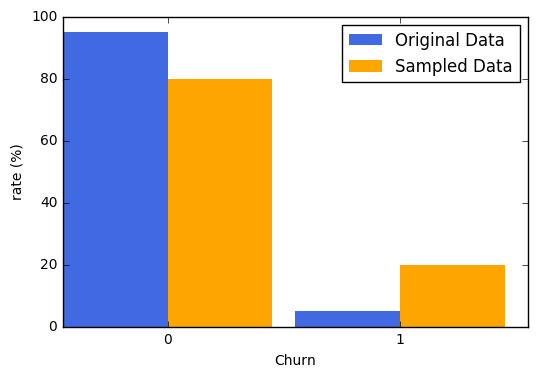

In [10]:
df1 = (100*data['Churn'].value_counts(normalize=True)).round()
df2 = (100*sample['Churn'].value_counts(normalize=True)).round()
plt.bar(df1.index,df1.values,width=0.45,color='#4169e1',edgecolor='none')
plt.bar(df2.index+0.45,df2.values,width=0.45,color='#ffa500',edgecolor='none')
plt.xticks([0.45,1.45],[0,1])
plt.xlabel("Churn")
plt.ylabel("rate (%)")
plt.legend(['Original Data','Sampled Data'])
plt.show()


# Exploratory Data Analysis

In this section, we will visually explore the data. Each variable will be compared to the target variable. We will use statistical tests to find how averages of independent variables are different in the two groups of churners and non-churners at 95% level of confidence. t-test will be used for numerical continuous variable and chisquare will be used for categorical variables.

The second part of this section, we use the principle component analysis to determing import variables. This is done as a validation of our statistical analysis


### Exploration of variables
#### Customers with age closer to 12 months are more likely to churn

In [11]:
for col in ['Longevity - Months','Longevity - Modulo 6','Longevity - Modulo 12',
            'Longevity - Modulo 18','Longevity - Modulo 24']:
    print col,test_stat(sample,col,'Churn',equal_var=False)

Longevity - Months Ttest_indResult(statistic=3.8636057408160154, pvalue=0.00012821254257113445)
Longevity - Modulo 6 Power_divergenceResult(statistic=2.8317746150914802, pvalue=0.72590191568099049)
Longevity - Modulo 12 Ttest_indResult(statistic=-3.7080462521898427, pvalue=0.00024065693434607843)
Longevity - Modulo 18 Ttest_indResult(statistic=6.7575160212700078, pvalue=5.2545252749935612e-11)
Longevity - Modulo 24 Ttest_indResult(statistic=4.4437679072589296, pvalue=1.1331027939944482e-05)


<img src="data/longevity-barplot.png">
<img src="data/longevity-boxplot.png">
With p-values less than 0.05, the statistical hypothesis test tells us that customers with age close to 12 monthers and older are more likely to churn at a 95% confidence level.

Similarly, we find the same significant difference in averages of longetivity derived varaibles, that is longetivity modulo 12, 18 and 24.

<img src="data/longevity12-boxplot.png">
<img src="data/longevity18-boxplot.png">
<img src="data/longevity24-boxplot.png">


#### Happier customers are less likely to churn

In [12]:
for col in ['Happiness Index - Current Month', 
            'Happiness Index - Change', 'Happiness Index - Monthly']:
    print col,":", test_stat(sample,col,'Churn',True,0)

Happiness Index - Current Month : Ttest_indResult(statistic=-5.3996770080139482, pvalue=8.0260878434484691e-08)
Happiness Index - Change : Ttest_indResult(statistic=-2.4409584663578516, pvalue=0.014790576525206389)
Happiness Index - Monthly : Ttest_indResult(statistic=-5.4646669650977344, pvalue=5.6241189118703731e-08)


<img src="data/happinessIndex_CM-boxplot.png">
<img src="data/happinessIndex_Change-boxplot.png">
<img src="data/happinessIndex_Monthly-boxplot.png">

Customers with higher current happiness index are less and less likely to churn. The t-test result in a pvalue smaller than 0.05 indicating that we have enough evidence to say that the average happiness index of non churners is higher than the one for churners. Similarly, we find same behaviour for change in happiness Index

#### Customers with  a constant activity are less likely to churn

The statistical test show that the average change in activity is zero in the group of non-churners compared to churners whose average is negative. This suggest that inactive customers are potential churnes as expected. This change in activity was measured as a combination of change in number of blogs, change in number of logins and change in number of views.

However, we fail to find any significant difference between average of change in number of blogs and change in number of views between the two groups

In [13]:
print "Mean Customer Activity - Change:"
print "\tNon-churners:",sample['Customer Activity - Change'][sample['Churn'] == 0].mean()
print "\tChurners:",sample['Customer Activity - Change'][sample['Churn'] == 1].mean()
print 'Customer Activity - Change',test_stat(sample,'Customer Activity - Change','Churn',False,0)
print "\n"
print 'Logins - Change',test_stat(sample,'Logins - Change','Churn',False,0)
print 'Blogs - Change',test_stat(sample,'Blogs - Change','Churn',False,0)
print 'Views - Change',test_stat(sample,'Views - Change','Churn',False,0)

Mean Customer Activity - Change:
	Non-churners: 0.00739396078998
	Churners: -0.129089911715
Customer Activity - Change Ttest_indResult(statistic=-3.1994126835867926, pvalue=0.0014974084017979913)


Logins - Change Ttest_indResult(statistic=-3.2133650743348157, pvalue=0.0014154488696597168)
Blogs - Change Ttest_indResult(statistic=-1.1917387860588311, pvalue=0.23403969444831776)
Views - Change Ttest_indResult(statistic=-1.5221528108328219, pvalue=0.12895940106710718)


<img src="data/CustomerActivity-Boxplot.png">

#### Customers who logged in most recently are less likely to churn

The statistical test show that the average change in days since last login smaller in the group of non-churners compared to churners. This suggest again that potential churners can be detected by tracking their last login day.

In [14]:
print "Days since last logins - Change:"
print "\tNon-churners:",sample['Days Since Last Login - Change'][sample['Churn'] == 0].mean()
print "\tChurners:",sample['Days Since Last Login - Change'][sample['Churn'] == 1].mean()
print 'Days Since Last Login - Change',test_stat(sample,'Days Since Last Login - Change','Churn',False,0)

Days since last logins - Change:
	Non-churners: 2.81432885891
	Churners: 7.92446967914
Days Since Last Login - Change Ttest_indResult(statistic=4.709098470467401, pvalue=3.8654483484154882e-06)


<img src='data/DaysSinceLastLogin-Boxplot.png'>

#### Support Cases


In [15]:
for col in ['Support Cases - Change','Support Cases - Current Month']:
    print col,":", test_stat(sample,col,'Churn',True,0)


Support Cases - Change : Power_divergenceResult(statistic=0.95664428770176069, pvalue=0.32803379769081453)
Support Cases - Current Month : Power_divergenceResult(statistic=1.0188541761196217, pvalue=0.31279095604288654)


With p-values greates than 0.05, our tests fail to show that there is enough statistical evidence that can imply that the average of support cases is  different in groups of churners and non-churners

#### Support Priority

As in support cases, there is not enough statistical evidence that there is difference in average of support priority in groups of churners versus non-churners

In [16]:
for col in ['Support Priority - Change','Support Priority - Current Month']:
    print col,":", test_stat(sample,col,'Churn',True,0)


Support Priority - Change : Power_divergenceResult(statistic=0.92063599332648138, pvalue=0.33730803658816599)
Support Priority - Current Month : Power_divergenceResult(statistic=1.026811915361854, pvalue=0.31090863503659427)


### Princple Component Analysis


If X is the dataset, we use PCA to learn coeffients (also known as loadings) **$L$** and a set of components **$C$** such that **$X = L \cdotp C$**. We will use PCA package available in scikit learn. We start by fitting the entire dataset to extract the number of useful components. Then the data is fitted again using the extracted number of important features.


number of useful components: 10


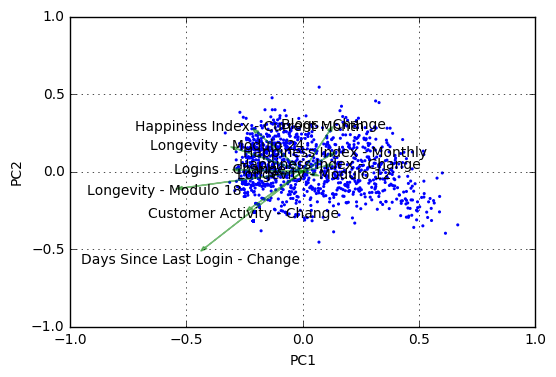

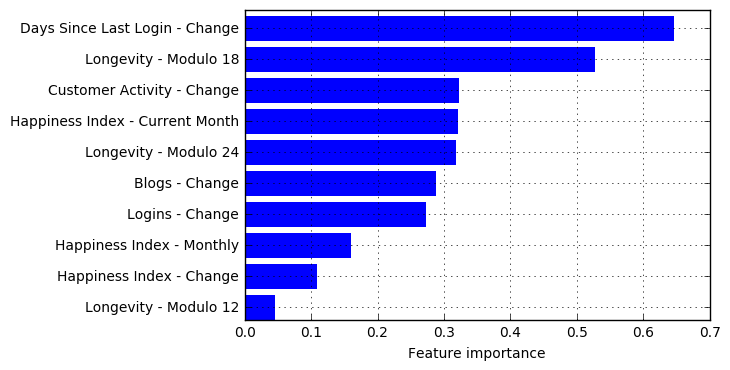

In [17]:
pca = PCA()
pca.fit(standardize(sample[labels1]),sample[target])
explained_var = pca.explained_variance_
n_comp = len(filter(lambda x:x>0.6, explained_var))
print "number of useful components:",n_comp

pca = PCA(n_components=n_comp)
pca.fit(standardize(sample[labels1]),sample[target])

loadings = pca.components_
scores = pca.transform(standardize(sample[labels1]))

vects = biplot(scores,loadings,1,2,labels=labels1)
vects = sorted(vects,key=lambda x:x[1])
plt.show()

labels_pca = map(lambda x:x[0],vects)

# Modeling


After observing so many variables whose averages are significantly different in the two groups of churners and non-churners, logistic regression would serve as a good candidate for model training.

We are going to train the basic model logistic regression with a regularization term C=1 and where our **numerical variables** (opposite to categorical variables) will be used as input and the churn variable will be used as the target. We will use 5 fold cross-validation to reduce possible overfitting. 

In [18]:
lr1 = modelfit(LogisticRegression(C=1.),sample[labels_pca],sample[target],printFeatureImportance=False,title='BasicLogisticRegression')

BasicLogisticRegression
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.713962
CV Score: Mean = 0.6432 | Std = 0.1121 | Min = 0.4377 | Max = 0.7663


The initial model has a mean AUC of 0.6375 and standard deviation of 0.0942. We are now going to proceed with a grid search to optimize the regularization term. The best C would return higher mean  AUC score.

In [19]:
Cs = 10**np.arange(-4.,4)
for c in Cs:
    modelfit(LogisticRegression(C=1.),sample[labels_pca],sample[target],printFeatureImportance=False,title='C:'+str(c))
#c=100
#lr1 = modelfit(LogisticRegression(C=c),Xvalid[labels1],Yvalid['Churn'],printFeatureImportance=False,title=str(c))
#res = evaluateModel(lr1['model'],sample[Xtrain.columns],sample.Churn,sample[Xtrain.columns],sample.Churn,title='Best LR',retrain=False)

C:0.0001
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714051
CV Score: Mean = 0.6435 | Std = 0.1118 | Min = 0.4385 | Max = 0.7663
C:0.001
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714034
CV Score: Mean = 0.6432 | Std = 0.1122 | Min = 0.4376 | Max = 0.7663
C:0.01
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714060
CV Score: Mean = 0.6435 | Std = 0.1118 | Min = 0.4385 | Max = 0.7663
C:0.1
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714064
CV Score: Mean = 0.6435 | Std = 0.1118 | Min = 0.4385 | Max = 0.7663
C:1.0
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714034
CV Score: Mean = 0.6434 | Std = 0.1118 | Min = 0.4385 | Max = 0.7663
C:10.0
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714038
CV Score: Mean = 0.6434 | Std = 0.1118 | Min = 0.4385 | Max = 0.7663
C:100.0
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714

**For final model, we choose the regularization factor C = 1**

In [20]:
c = 1
lrf = modelfit(LogisticRegression(C=c),sample[labels_pca],sample[target],printFeatureImportance=False,title='C:'+str(c))

C:1
-------------------------------
Accuracy: 0.8181
AUC Score (Train): 0.714047
CV Score: Mean = 0.6432 | Std = 0.1122 | Min = 0.4376 | Max = 0.7663


## 3. Model Validation

In [21]:
model = lrf['model']
preds = model.predict(_Xvalid[labels_pca])
print "Validation of the model on the validation dataset"
print "auc score:\n\t", roc_auc_score(_Yvalid,preds)
print "confusion matrix:\n", tabulate(pd.DataFrame(confusion_matrix(_Yvalid,preds)),headers=[0,1])



Validation of the model on the validation dataset
auc score:
	0.585069674851
confusion matrix:
       0    1
--  ----  ---
 0  1462   45
 1    64   16


In [22]:
#save model on disk
with open("model.pkl","wb") as mdl:
    pickle.dump(model,mdl)
    mdl.close()

# Recommendations

### How can the company allocate funds to retain potential churners?

Assume the expense to adopt one customer x1 and teh the monthly revenue collected from each member r1 are known. Here, we are trying to estimate the money to invest in promotion to keep a predicted churner, x2.


Since we also know that the average longetivity is 12.6 months.

We can now optimize potential losses due to false predictions.

Loss due to false negative consists in the difference between the money collected from the customer and adoption expense

$FN_{Loss}= 12.6*r_1 - x_1$

Loss due to false positive consists in the money invested in promotion per potential churner

$FP_{Loss} = x_2$

In order to decide which value to allocate on each potential churner, the company need to take into account the two potential losses above balanced with total loss of churners in case the model was absent.

$64*(12.6*r_1 - x_1)+45*x_2 = 80*(12.6*r_1 - x_1)$

And finally 

$x_2 < (16/45)*(12.6*r_1 - x_1)$

In [6]:
def x2(x1,r1):
    return (12.6*r1 - x1)*16/float(45)

print "for x1=100 and r1=20, the retaintion incentive can be estimated to ",round(x2(100,20))

for x1=100 and r1=20, the retaintion incentive can be estimated to  54.0


### Characteristics of churners:
Based on our exploratory and statistical analysis we suggest the company prepare money for incentives to retain potential churners. As potential churners of interest, they should:
1. watch closely customers who are in the proximity of 12, 18 and 24 months longevity
2. watch closely customers with a negative change in activity especially those who decreased their login frequency
3. reach out to those customers who haven't logged in for a while (>15 days).

### Model Improvement:

To improve the model, more data should be provided. Churning problem is a case of unbalanced dataset where resampling is used to boost the positive rate. For a better accuracy, it is advised to have larger datasets

# Appendix

#### Function to make predictions

This function provides the user a fast way to make predictions over a dataset

**Example**

In [23]:
def make_predictions(df):
    """
    This function provides the user a fast way to make predictions over a dataset
    """
    t_labels = get_labels("labels_pca")
    # clean data
    df = clean_data(df)
    # engineer data
    df = engineer_features(df)
    # predict
    with open("model.pkl","r") as mdl:
        model = pickle.load(mdl)
        mdl.close()
    predictions = model.predict(df[t_labels])
    return predictions